# Unsupervised anomaly detection
After our initial EDA, we have decided to pursue some unsupervised anomaly detection with a feature for the number of usernames with a failed login attempt in a given minute.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

with sqlite3.connect('logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        'SELECT * FROM logs WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
logs_2018.head()

,source_ip,username,success,failure_reason
datetime,,,,
2018-01-01 00:05:32.988414,223.178.55.3,djones,1,None
2018-01-01 00:08:00.343636,223.178.55.3,djones,0,error_wrong_password
2018-01-01 00:08:01.343636,223.178.55.3,djones,1,None
2018-01-01 01:06:59.640823,208.101.11.88,wbrown,1,None
2018-01-01 02:40:47.769630,11.76.99.35,tkim,1,None


## Prepping our data
We need a function to transform our log data into our X for the model:

In [2]:
def get_X(log, day):
    """
    Get data we can use for the X
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
    
    Returns: 
        A `pandas.DataFrame` object
    """
    return pd.get_dummies(log.loc[day].assign(
        failures=lambda x: 1 - x.success
    ).query('failures > 0').resample('1min').agg(
        {'username': 'nunique', 'failures': 'sum'}
    ).dropna().rename(
        columns={'username': 'usernames_with_failures'}
    ).assign(
        day_of_week=lambda x: x.index.dayofweek, 
        hour=lambda x: x.index.hour
    ).drop(columns=['failures']), columns=['day_of_week', 'hour'])

We will work with January 2018:

In [3]:
X = get_X(logs_2018, '2018-01')
X.columns

Index(['usernames_with_failures', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

## Isolation Forest
with estimated 5% contamination:

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

iso_forest_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('iforest', IsolationForest(
        random_state=0, contamination=0.05
    ))
]).fit(X)

Let's see how many outliers versus inliers we got. Outliers will be marked as -1:

In [5]:
isolation_forest_preds = iso_forest_pipeline.predict(X)
pd.Series(np.where(
    isolation_forest_preds == -1, 'outlier', 'inlier'
)).value_counts()

inlier     42556
outlier     2001
dtype: int64

### Local Outlier Factor
Since we have no labeled data, we can't use grid search to tune our hyperparameters (we can't calculate performance metrics). Therefore, we will accept the default parameters for LOF, which will use 20 neighbors:

In [6]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lof_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lof', LocalOutlierFactor())
]).fit(X)

This model comes up with a negative outlier factor, which doesn't tell us outlier/inlier on its own:

In [7]:
lof_preds = lof_pipeline.named_steps['lof'].negative_outlier_factor_ 
lof_preds

array([-1.33898756e+10, -1.00000000e+00, -1.00000000e+00, ...,
       -1.00000000e+00, -1.00000000e+00, -1.11582297e+10])

For that, we need to compare it to the offset. Values less than the offset are outliers:

In [8]:
pd.Series(np.where(
    lof_preds < lof_pipeline.named_steps['lof'].offset_, 'outlier', 'inlier'
)).value_counts()

inlier     44248
outlier      309
dtype: int64

### Check agreement between unsupervised methods
While we can't compare their performance without labeled data, we can see if they are generally in agreement (there is a low level of agreement):

In [9]:
from sklearn.metrics import cohen_kappa_score

is_lof_outlier = np.where(
    lof_preds < lof_pipeline.named_steps['lof'].offset_, 
    'outlier', 'inlier'
)
is_iso_outlier = np.where(
    isolation_forest_preds == -1, 'outlier', 'inlier'
)

cohen_kappa_score(is_lof_outlier, is_iso_outlier)

0.25862517997335677

### Evaluating the models
We have been given the labeled data. Now we can truly compare these models.

In [10]:
with sqlite3.connect('logs/logs.db') as conn:
    hackers_jan_2018 = pd.read_sql(
        """
        SELECT * 
        FROM attacks 
        WHERE start BETWEEN "2018-01-01" AND "2018-02-01";
        """, conn, parse_dates=['start', 'end']
    ).assign(
        duration=lambda x: x.end - x.start,
        start_floor=lambda x: x.start.dt.floor('min'),
        end_ceil=lambda x: x.end.dt.ceil('min')
    )
hackers_jan_2018.shape

(7, 6)

Note this only has an IP address for one of the IP addresses involved in each attack, so it's a good thing we aren't relying on that anymore. Also note that, while the attacks are quick in duration, our minutely data means we will trigger many alerts per attack:

In [11]:
hackers_jan_2018

,start,end,source_ip,duration,start_floor,end_ceil
0,2018-01-02 02:31:43.326264,2018-01-02 02:35:16.326264,102.139.159.128,0 days 00:03:33,2018-01-02 02:31:00,2018-01-02 02:36:00
1,2018-01-02 20:14:02.279476,2018-01-02 20:14:28.279476,119.218.239.234,0 days 00:00:26,2018-01-02 20:14:00,2018-01-02 20:15:00
2,2018-01-03 01:25:48.667114,2018-01-03 01:29:13.667114,151.93.164.203,0 days 00:03:25,2018-01-03 01:25:00,2018-01-03 01:30:00
3,2018-01-08 21:41:43.985324,2018-01-08 21:45:56.985324,226.98.192.152,0 days 00:04:13,2018-01-08 21:41:00,2018-01-08 21:46:00
4,2018-01-11 17:38:30.974748,2018-01-11 17:42:33.974748,23.81.78.129,0 days 00:04:03,2018-01-11 17:38:00,2018-01-11 17:43:00
5,2018-01-12 03:32:20.284167,2018-01-12 03:36:29.284167,74.90.28.4,0 days 00:04:09,2018-01-12 03:32:00,2018-01-12 03:37:00
6,2018-01-31 07:39:17.514901,2018-01-31 07:43:29.514901,236.174.156.247,0 days 00:04:12,2018-01-31 07:39:00,2018-01-31 07:44:00


We want to mark each minute that had an attack, so we can use the `start_floor` and `end_ceil` columns to create a range of datetimes. Then, we can check if the data we marked as outliers falls within that range:

In [12]:
def get_y(datetimes, hackers, resolution='1min'):
    """
    Get data we can use for the y (whether or not a hacker attempted a log in during that time).
    
    Parameters:
        - datetimes: The datetimes to check for hackers
        - hackers: The dataframe indicating when the attacks started and stopped
        - resolution: The granularity of the datetime. Default is 1 minute.
        
    Returns:
        `pandas.Series` of Booleans.
    """
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series(dtype='object')
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

Let's grab our labeled `y` data:

In [13]:
is_hacker = get_y(X.reset_index().datetime, hackers_jan_2018)

We will create partials for the performance metrics functions for less typing:

In [14]:
from functools import partial
from sklearn.metrics import classification_report
from ml_utils.classification import confusion_matrix_visual

report = partial(classification_report, is_hacker)
conf_matrix = partial(
    confusion_matrix_visual, is_hacker, class_labels=[False, True]
)

#### Isolation forest

In [15]:
iso_forest_predicts_hacker = isolation_forest_preds == - 1

print(report(iso_forest_predicts_hacker))

              precision    recall  f1-score   support

       False       1.00      0.96      0.98     44519
        True       0.02      0.82      0.03        38

    accuracy                           0.96     44557
   macro avg       0.51      0.89      0.50     44557
weighted avg       1.00      0.96      0.98     44557



#### Local Outlier Factor

In [16]:
lof_predicts_hacker = lof_preds < lof_pipeline.named_steps['lof'].offset_

print(report(lof_predicts_hacker))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00     44519
        True       0.03      0.26      0.06        38

    accuracy                           0.99     44557
   macro avg       0.52      0.63      0.53     44557
weighted avg       1.00      0.99      1.00     44557



#### Comparing confusion matrices

<AxesSubplot:title={'center':'Local Outlier Factor'}, xlabel='Actual', ylabel='Model Prediction'>

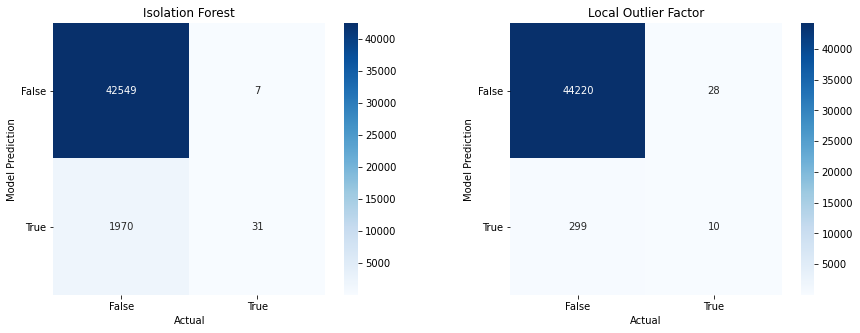

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
conf_matrix(iso_forest_predicts_hacker, ax=axes[0], title='Isolation Forest')
conf_matrix(lof_predicts_hacker, ax=axes[1], title='Local Outlier Factor')

<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
        <a href="./1-EDA_unlabeled_data.ipynb">
            <button>&#8592; Previous Notebook</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="./3-EDA_labeled_data.ipynb">
            <button>Next Notebook &#8594;</button>
        </a>
    </div>
</div>
<hr>